In [2]:
import os, sys, glob, argparse
import pandas as pd
import numpy as np
from tqdm import tqdm

%pylab inline

import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [6]:
train_path = glob.glob('./农民身份识别挑战赛公开数据/train/*')
test_path = glob.glob('./农民身份识别挑战赛公开数据/test/*')

train_path.sort()
test_path.sort()

In [11]:
train_df = pd.read_csv('农民身份识别挑战赛公开数据/train.csv')
train_df = train_df.sort_values(by='name')
train_label = train_df['label'].values

In [14]:
np.max(train_label), np.min(train_label), np.unique(train_label)

(24,
 0,
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]))

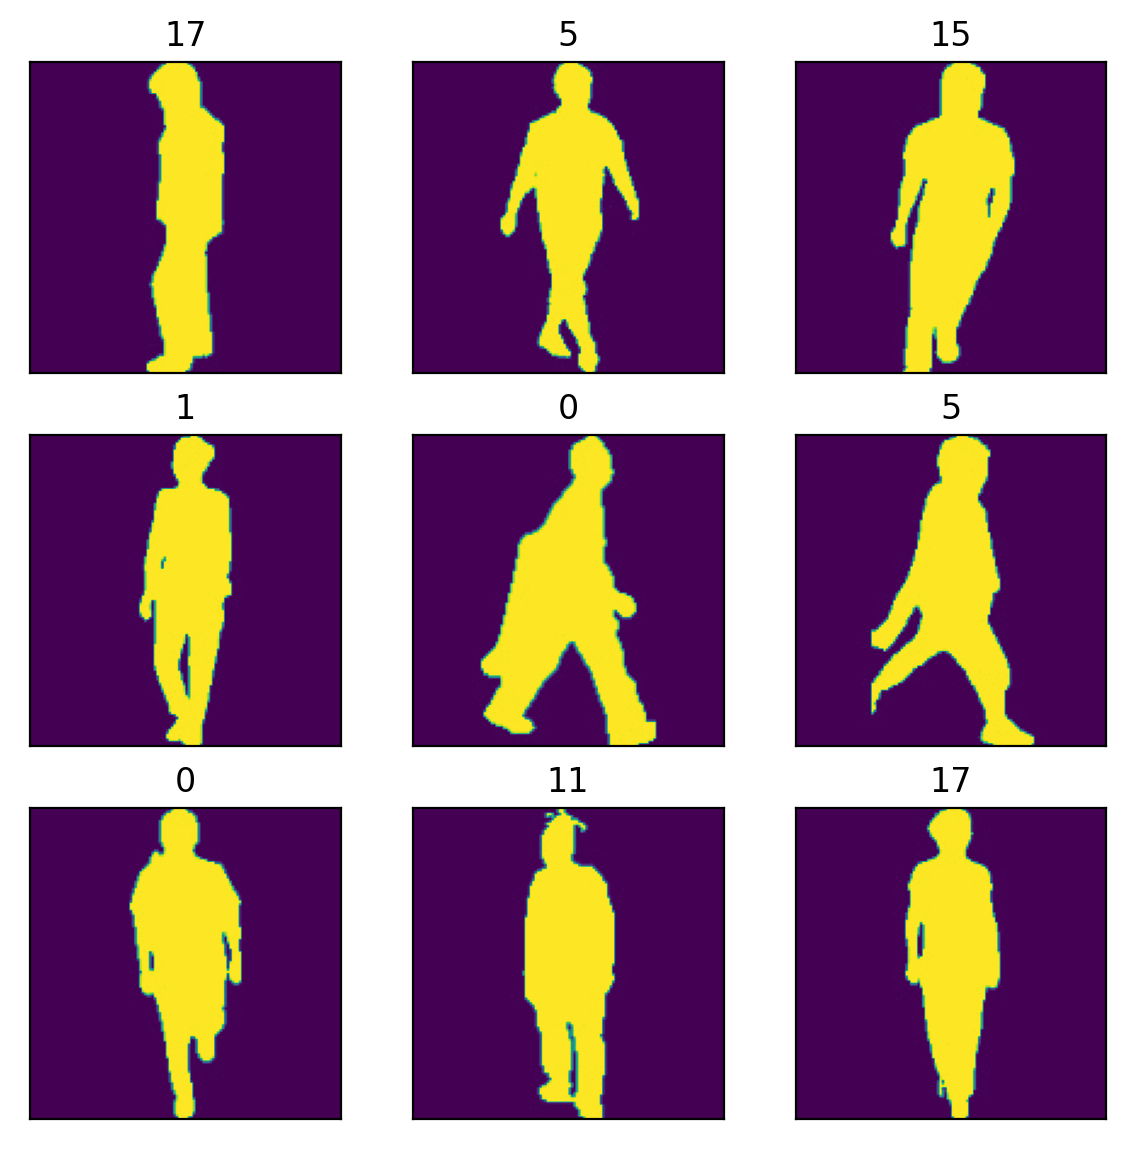

In [12]:
plt.figure(figsize=(7, 7), dpi=200)
for idx in range(9):
    plt.subplot(3, 3, idx+1)
    plt.imshow(Image.open(train_path[idx]))
    plt.xticks([]);
    plt.yticks([]);
    plt.title(train_label[idx])

In [19]:
DATA_CACHE = {}
class XunFeiDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None
    def __getitem__(self, index):
        if self.img_path[index] in DATA_CACHE:
            img = DATA_CACHE[self.img_path[index]]
        else:
            img = cv2.imread(self.img_path[index])
            DATA_CACHE[self.img_path[index]] = img
        if self.transform is not None:
            img = self.transform(image = img)['image']
        img = img.transpose([2,0,1])
        return img, torch.from_numpy(np.array(self.img_label[index]))
    def __len__(self):
        return len(self.img_path)

In [20]:
class XunFeiNet(nn.Module):
    def __init__(self):
        super(XunFeiNet, self).__init__()
        model = models.resnet18(True)
        model.avgpool = nn.AdaptiveAvgPool2d(1)
        model.fc = nn.Linear(512, 25)
        self.resnet = model
    def forward(self, img):
        out = self.resnet(img)
        return out

In [26]:
def train(train_loader, model, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for i, (input, target) in enumerate(train_loader):
        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('Train loss', loss.item())
            
        train_loss += loss.item()
    
    return train_loss/len(train_loader)
            
def validate(val_loader, model, criterion):
    model.eval()
    
    val_acc = 0.0
    
    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda()
            target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)
            
            val_acc += (output.argmax(1) == target).sum().item()
            
    return val_acc / len(val_loader.dataset)

def predict(test_loader, model, criterion):
    model.eval()
    val_acc = 0.0
    
    test_pred = []
    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(test_loader):
            input = input.cuda()
            target = target.cuda()

            # compute output
            output = model(input)
            test_pred.append(output.data.cpu().numpy())
            
    return np.vstack(test_pred)

In [27]:
import albumentations as A

train_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_path[:-1000], train_label[:-1000],
            A.Compose([
            A.RandomRotate90(),
            A.Resize(256, 256),
            A.RandomCrop(224, 224),
            A.HorizontalFlip(p=0.5),
            A.RandomContrast(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
    ), batch_size=30, shuffle=True, num_workers=1, pin_memory=False
)

val_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_path[-1000:], train_label[-1000:],
            A.Compose([
            A.Resize(256, 256),
            A.RandomCrop(224, 224),
            # A.HorizontalFlip(p=0.5),
            # A.RandomContrast(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
    ), batch_size=30, shuffle=False, num_workers=1, pin_memory=False
)

test_loader = torch.utils.data.DataLoader(
    XunFeiDataset(test_path, [0] * len(test_path),
            A.Compose([
            A.Resize(256, 256),
            A.RandomCrop(224, 224),
            A.HorizontalFlip(p=0.5),
            A.RandomContrast(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
    ), batch_size=2, shuffle=False, num_workers=1, pin_memory=False
)

In [28]:
for data, lable in train_loader:
    break

In [29]:
model = XunFeiNet()
model = model.to('cuda')
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.AdamW(model.parameters(), 0.001)

In [30]:
for _  in range(8):
    train_loss = train(train_loader, model, criterion, optimizer)
    val_acc  = validate(val_loader, model, criterion)
    train_acc = validate(train_loader, model, criterion)
    
    print(train_loss, train_acc, val_acc)

Train loss 3.3764824867248535
Train loss 2.962838649749756
Train loss 2.735387086868286
Train loss 2.7186777591705322
Train loss 2.479957342147827
Train loss 2.2384378910064697
Train loss 2.1143879890441895
Train loss 2.109005928039551
2.505831791829476 0.24671412924424974 0.28
Train loss 1.9086700677871704
Train loss 2.347980499267578
Train loss 1.9721630811691284
Train loss 1.816836953163147
Train loss 1.8843234777450562
Train loss 1.2556504011154175
Train loss 2.098001480102539
Train loss 1.935025930404663
1.8574956458179146 0.462166849215042 0.515
Train loss 2.2689576148986816
Train loss 1.1673381328582764
Train loss 1.9554883241653442
Train loss 1.2551671266555786
Train loss 1.2400397062301636
Train loss 1.0628771781921387
Train loss 1.663795828819275
Train loss 1.6931358575820923
1.4827974174482552 0.5031489594742606 0.541
Train loss 1.4015883207321167
Train loss 1.2313812971115112
Train loss 1.2634450197219849
Train loss 1.217300534248352
Train loss 1.2080681324005127
Train loss

In [31]:
pred = None

for _ in range(10):
    if pred is None:
        pred = predict(test_loader, model, criterion)
    else:
        pred += predict(test_loader, model, criterion)

In [32]:
submit = pd.DataFrame(
    {
        'name': [x.split('/')[-1] for x in test_path],
        'label': pred.argmax(1)
})

In [34]:
submit = submit.sort_values(by='name')
submit.to_csv('submit.csv', index=None)